In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install

In [4]:
import shutil

# Define the source and destination paths
source_folder = '/content/drive/MyDrive/Aquarium Combined'
destination_folder = '/content/myfolder'

# Copy the folder
shutil.copytree(source_folder, destination_folder)
print("Folder copied to Colab working directory!")


Folder copied to Colab working directory!


In [5]:
!pip3 install pycocotools

In [6]:
import os
import random
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pycocotools.coco import COCO

**Using PYCOCOTOOLS**

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


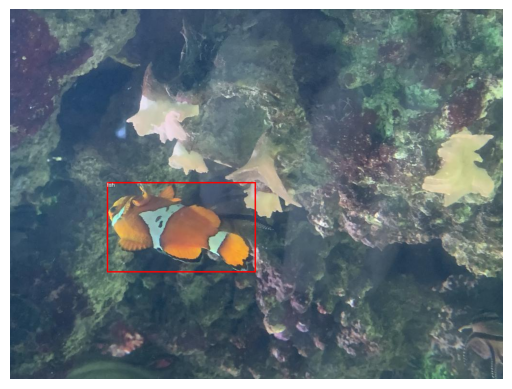

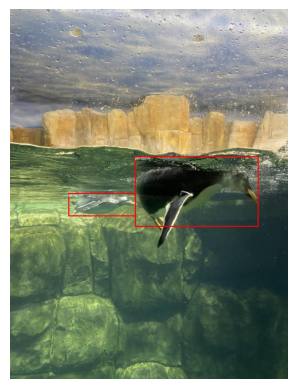

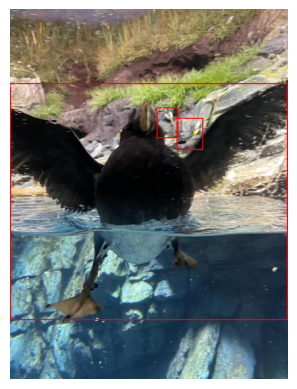

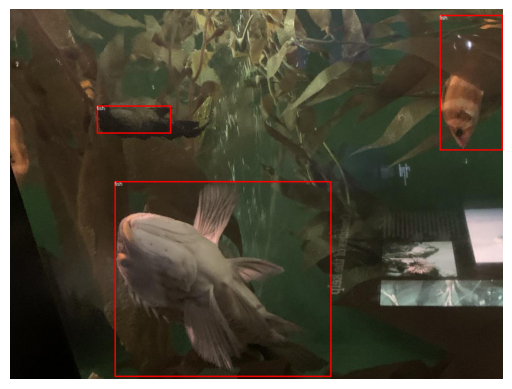

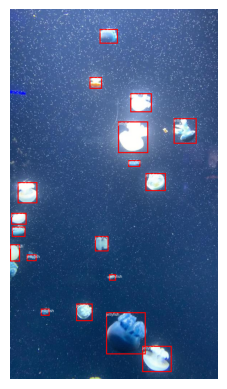

In [7]:
# Define paths to the dataset directories
train_dir = '/content/Aquarium/train'
annotations_path = os.path.join(train_dir, '_annotations.coco.json')

# Load the COCO annotations
def load_coco_annotations(annotations_file):
    return COCO(annotation_file=annotations_file)

# Function to visualize image with bounding boxes and labels
def visualize_coco_image(coco, img_dir, img_info):
    img_path = os.path.join(img_dir, img_info['file_name'])

    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)

    # Load annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(ann_ids)

    # Draw bounding boxes and class labels
    for ann in anns:
        bbox = ann['bbox']
        category = coco.loadCats(ann['category_id'])[0]['name']  # Get class name

        # COCO format: bbox = [x_min, y_min, width, height]
        x_min, y_min, width, height = bbox
        x_max, y_max = x_min + width, y_min + height

        # Draw the bounding box
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

        # Add the class label on top of the bounding box
        draw.text((x_min, y_min), category, fill="white")

    # Show the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Function to randomly visualize 5 images from the dataset
def visualize_random_images(coco, img_dir):
    img_ids = coco.getImgIds()
    sample_img_ids = random.sample(img_ids, 5)

    for img_id in sample_img_ids:
        img_info = coco.loadImgs(img_id)[0]
        visualize_coco_image(coco, img_dir, img_info)

# Load the annotations
coco = load_coco_annotations(annotations_path)

# Visualize random images from the training dataset
visualize_random_images(coco, train_dir)


In [8]:
!pip3 install pycocotools torchsummary

# **Main Code for Faster RCNN Training**

1.1 Installing Packages

In [11]:
!pip install torchinfo


1.2 Loading Packages

In [12]:
import os
import numpy as np
import pandas as pd

# Import necessary libraries for data transformation and dataset handling
import albumentations as A  # For data augmentation
from albumentations.pytorch import ToTensorV2  # To convert images to tensor
from torch.utils.data import Dataset, DataLoader  # PyTorch data handling
from pycocotools.coco import COCO  # COCO format handling
import cv2  # For image loading and processing
import torch  # PyTorch main library
from torchvision import models  # Pretrained models from PyTorch
import torch.optim as optim  # Optimizers
from tqdm import tqdm  # For progress bar in training loop
import warnings  # For managing warnings

from torchinfo import summary
import torch
from typing import List, Tuple
import numpy as np

import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import random

In [13]:
# Suppress warnings
warnings.filterwarnings("ignore")
%matplotlib inline

1.3 Transform the input images

In [14]:
# Data transformations for training data
def get_train_transforms():
    """
    Returns transformation pipeline for training images with augmentations
    including resizing, flipping, brightness/contrast adjustments, and color jitter.
    """
    return A.Compose([
        A.Resize(600, 600),  # Resize images to 600x600 pixels
        A.HorizontalFlip(p=0.3),  # Apply horizontal flip with a probability of 30%
        A.VerticalFlip(p=0.3),  # Apply vertical flip with a probability of 30%
        A.RandomBrightnessContrast(p=0.1),  # Adjust brightness/contrast with 10% probability
        A.ColorJitter(p=0.1),  # Random color jitter with 10% probability
        ToTensorV2()  # Convert the image to a PyTorch tensor
    ], bbox_params=A.BboxParams(format='coco'))  # Bounding box format in COCO style


## 1.4 Transform Test Images


In [15]:
# Data transformations for test data (without augmentations)
def get_test_transforms():
    """
    Returns transformation pipeline for test images, only resizing and tensor conversion.
    """
    return A.Compose([
        A.Resize(600, 600),  # Resize images to 600x600 pixels
        ToTensorV2()  # Convert the image to a PyTorch tensor
    ], bbox_params=A.BboxParams(format='coco'))  # Bounding box format in COCO style


1.5 Creating Custom Class for data laoding

In [16]:
# Custom Dataset class for Aquarium Detection
class AquariumDetection(Dataset):
    def __init__(self, root, split='train', transforms=None):
        """
        Initializes dataset with root path, split (train/test), and transformations.
        Loads COCO annotations and filters images with annotations.

        Parameters:
        - root: path to the dataset
        - split: 'train' or 'test' to select dataset split
        - transforms: data augmentation transformations
        """
        self.root = root
        self.split = split
        self.transforms = transforms
        # Load COCO format annotations
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        # Filter image IDs that have at least one annotation
        self.ids = [img_id for img_id in sorted(self.coco.imgs.keys())
                    if len(self.coco.getAnnIds(img_id)) > 0]

    def __getitem__(self, index):
        """
        Retrieves image and target (bounding boxes and labels) by index.

        Parameters:
        - index: index to select image and target
        Returns:
        - Transformed image tensor and target dictionary
        """
        img_id = self.ids[index]  # Get image ID
        image = self.load_image(img_id)  # Load image using ID
        annotations = self.coco.loadAnns(self.coco.getAnnIds(img_id))  # Load annotations
        boxes = [ann['bbox'] + [ann['category_id']] for ann in annotations]  # Extract bounding boxes

        # Apply transformations if specified
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes)
            image = transformed['image']
            boxes = transformed['bboxes']

        # Convert bounding boxes to tensor format (x_min, y_min, x_max, y_max)
        boxes = torch.tensor([[x, y, x + w, y + h] for x, y, w, h, _ in boxes], dtype=torch.float32)
        labels = torch.tensor([ann['category_id'] for ann in annotations], dtype=torch.int64)  # Labels
        iscrowd = torch.tensor([ann.get('iscrowd', 0) for ann in annotations], dtype=torch.int64)  # Crowd labels

        # Prepare target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),  # Area of boxes
            'iscrowd': iscrowd
        }
        return image.div(255), target  # Normalize image

    def load_image(self, img_id):
        """
        Loads image from file path using OpenCV and converts to RGB.

        Parameters:
        - img_id: image ID to load
        Returns:
        - Loaded RGB image
        """
        img_path = self.coco.loadImgs(img_id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, img_path))
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    def __len__(self):
        """Returns the total number of images with annotations in the dataset."""
        return len(self.ids)

1.5 Initialising the custom class data processor

In [17]:
# Model and training setup
dataset_path = "/content/Aquarium"
train_dataset = AquariumDetection(root=dataset_path, transforms=get_train_transforms())

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


1.6 Initialising Faster RCNN model

In [18]:
# Modify the Faster R-CNN model for custom class predictions
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(
    model.roi_heads.box_predictor.cls_score.in_features, len(train_dataset.coco.cats)
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 169MB/s]


1.7 Checking Model Summary

In [19]:
def print_model_summary(model, input_size: Tuple[int, int, int, int] = (1, 3, 600, 600)):
    """
    Prints a detailed summary of a PyTorch model, similar to Keras model.summary()

    Parameters:
    - model: PyTorch model to summarize
    - input_size: Tuple of (batch_size, channels, height, width) for input tensor
    """
    try:
        # Create a dummy input tensor for the model
        dummy_input = torch.randn(input_size)

        # Get model summary using torchinfo
        model_stats = summary(
            model,
            input_size=(input_size,),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"]
        )

        # Print additional model statistics
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print("\nModel Statistics:")
        print(f"Total Parameters: {total_params:,}")
        print(f"Trainable Parameters: {trainable_params:,}")
        print(f"Non-trainable Parameters: {total_params - trainable_params:,}")

        return model_stats

    except Exception as e:
        print(f"Error generating model summary: {str(e)}")
        print("\nFalling back to basic summary...")

        # Fallback to basic parameter summary
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print("\nBasic Model Statistics:")
        print(f"Total Parameters: {total_params:,}")
        print(f"Trainable Parameters: {trainable_params:,}")
        print(f"Non-trainable Parameters: {total_params - trainable_params:,}")

In [20]:
# Print model summary
print_model_summary(model)


Model Statistics:
Total Parameters: 18,960,979
Trainable Parameters: 18,902,083
Non-trainable Parameters: 58,896


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
FasterRCNN (FasterRCNN)                                           [1, 3, 600, 600]     [0, 4]               --                   Partial
├─GeneralizedRCNNTransform (transform)                            [1, 3, 600, 600]     [1, 3, 800, 800]     --                   --
├─BackboneWithFPN (backbone)                                      [1, 3, 800, 800]     [1, 256, 13, 13]     --                   Partial
│    └─IntermediateLayerGetter (body)                             [1, 3, 800, 800]     [1, 960, 25, 25]     --                   Partial
│    │    └─Conv2dNormActivation (0)                              [1, 3, 800, 800]     [1, 16, 400, 400]    (432)                False
│    │    └─InvertedResidual (1)                                  [1, 16, 400, 400]    [1, 16, 400, 400]    (400)                False
│    │    └─InvertedResidual (2)                

1.8 Initialise Optimisers

In [21]:
# Optimizer setup with SGD
params = [p for p in model.parameters() if p.requires_grad]  # Only parameters with gradients
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)  # SGD optimizer


1.9 Creating function to train one epoch

In [22]:
# Training loop for one epoch
def train_one_epoch(model, optimizer, loader, device, epoch):
    """
    Trains the model for one epoch, accumulating and printing losses.

    Parameters:
    - model: neural network model
    - optimizer: optimizer for backpropagation
    - loader: dataloader for training data
    - device: device to run computations (CPU/GPU)
    - epoch: current epoch number
    """
    model.train()
    total_loss = 0  # Initialize total loss for epoch
    loss_dict_accumulated = {  # Initialize dictionary to accumulate losses
        'loss_classifier': 0,
        'loss_box_reg': 0,
        'loss_objectness': 0,
        'loss_rpn_box_reg': 0
    }
    num_batches = len(loader)

    # Iterate through batches of images and targets
    for images, targets in tqdm(loader):
        images = [img.to(device) for img in images]  # Move images to device
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to device

        # Calculate model losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())  # Sum all losses
        total_loss += losses.item()

        # Accumulate each loss type for averaging
        for key, loss_val in loss_dict.items():
            loss_dict_accumulated[key] += loss_val.item()

        # Backpropagation step
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Calculate and print average losses
    avg_total_loss = total_loss / num_batches
    avg_loss_dict = {key: val / num_batches for key, val in loss_dict_accumulated.items()}
    print(f"Epoch {epoch}:")
    print(f"  Average Total Loss: {avg_total_loss:.4f}")
    for loss_name, avg_loss in avg_loss_dict.items():
        print(f"  Average {loss_name}: {avg_loss:.4f}")


1.10 Initialise data loaders

In [23]:
# Dataloader and Training Execution
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device
model.to(device)  # Move model to device

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

1.11 Main training for 10 epochs

In [24]:
# Training loop across 10 epochs
for epoch in range(10):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 112/112 [00:20<00:00,  5.55it/s]


Epoch 0:
  Average Total Loss: 1.0796
  Average loss_classifier: 0.5250
  Average loss_box_reg: 0.4378
  Average loss_objectness: 0.0848
  Average loss_rpn_box_reg: 0.0320


100%|██████████| 112/112 [00:18<00:00,  6.19it/s]


Epoch 1:
  Average Total Loss: 0.8465
  Average loss_classifier: 0.4011
  Average loss_box_reg: 0.3585
  Average loss_objectness: 0.0593
  Average loss_rpn_box_reg: 0.0276


100%|██████████| 112/112 [00:17<00:00,  6.29it/s]


Epoch 2:
  Average Total Loss: 0.7771
  Average loss_classifier: 0.3484
  Average loss_box_reg: 0.3545
  Average loss_objectness: 0.0488
  Average loss_rpn_box_reg: 0.0254


100%|██████████| 112/112 [00:17<00:00,  6.27it/s]


Epoch 3:
  Average Total Loss: 0.7096
  Average loss_classifier: 0.2975
  Average loss_box_reg: 0.3460
  Average loss_objectness: 0.0425
  Average loss_rpn_box_reg: 0.0236


100%|██████████| 112/112 [00:17<00:00,  6.36it/s]


Epoch 4:
  Average Total Loss: 0.6663
  Average loss_classifier: 0.2677
  Average loss_box_reg: 0.3382
  Average loss_objectness: 0.0375
  Average loss_rpn_box_reg: 0.0229


100%|██████████| 112/112 [00:17<00:00,  6.35it/s]


Epoch 5:
  Average Total Loss: 0.6450
  Average loss_classifier: 0.2547
  Average loss_box_reg: 0.3312
  Average loss_objectness: 0.0369
  Average loss_rpn_box_reg: 0.0222


100%|██████████| 112/112 [00:17<00:00,  6.51it/s]


Epoch 6:
  Average Total Loss: 0.6243
  Average loss_classifier: 0.2389
  Average loss_box_reg: 0.3308
  Average loss_objectness: 0.0335
  Average loss_rpn_box_reg: 0.0212


100%|██████████| 112/112 [00:17<00:00,  6.55it/s]


Epoch 7:
  Average Total Loss: 0.6228
  Average loss_classifier: 0.2351
  Average loss_box_reg: 0.3353
  Average loss_objectness: 0.0319
  Average loss_rpn_box_reg: 0.0205


100%|██████████| 112/112 [00:17<00:00,  6.33it/s]


Epoch 8:
  Average Total Loss: 0.6204
  Average loss_classifier: 0.2292
  Average loss_box_reg: 0.3426
  Average loss_objectness: 0.0282
  Average loss_rpn_box_reg: 0.0204


100%|██████████| 112/112 [00:17<00:00,  6.42it/s]

Epoch 9:
  Average Total Loss: 0.6303
  Average loss_classifier: 0.2325
  Average loss_box_reg: 0.3496
  Average loss_objectness: 0.0278
  Average loss_rpn_box_reg: 0.0204


Plotting images with predicitons

In [25]:
# Define a helper function for visualization
def plot_images_with_predictions(original_image, predictions, labels_map):
    plt.figure(figsize=(12, 6))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Display image with predictions
    plt.subplot(1, 2, 2)
    plt.imshow(original_image)
    plt.title("Predicted Objects")

    # Draw bounding boxes and labels on the predicted image
    for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
        if score >= 0.5:  # Confidence threshold
            box = box.int().tolist()
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                              linewidth=2, edgecolor='red', facecolor='none'))
            plt.text(box[0], box[1] - 5, f"{labels_map[label.item()]}: {score:.2f}", color='red', fontsize=12)

    plt.axis("off")
    plt.show()

Model predicitons

In [26]:
# Evaluation function
def evaluate(model, test_loader, device, labels_map):
    model.eval()
    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            # Process each image in the batch
            for i, output in enumerate(outputs):
                original_image = F.to_pil_image(images[i].cpu())

                # Move tensors to CPU for visualization
                predictions = {
                    'boxes': output['boxes'].cpu(),
                    'labels': output['labels'].cpu(),
                    'scores': output['scores'].cpu()
                }

                # Display the original and predicted image side by side
                plot_images_with_predictions(original_image, predictions, labels_map)

            # Break after first batch to limit visualization to a few images
            break

Initialising predicitons

{0: 'creatures', 1: 'fish', 2: 'jellyfish', 3: 'penguin', 4: 'puffin', 5: 'shark', 6: 'starfish', 7: 'stingray'}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


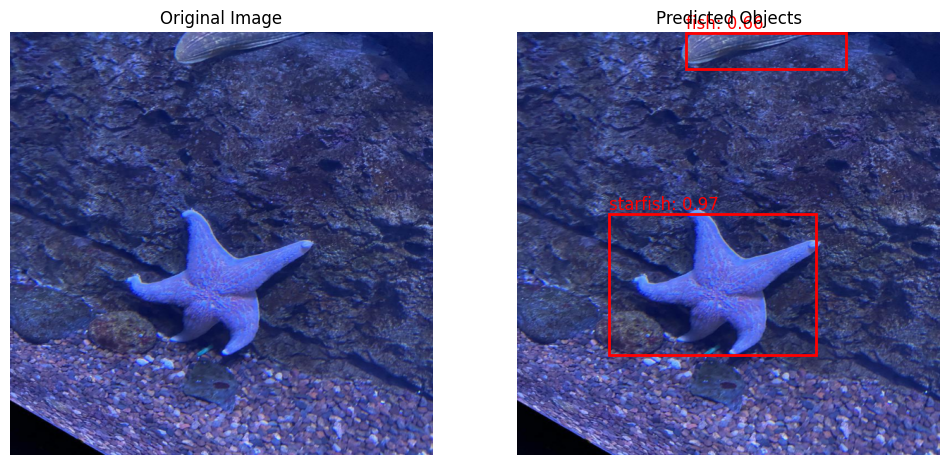

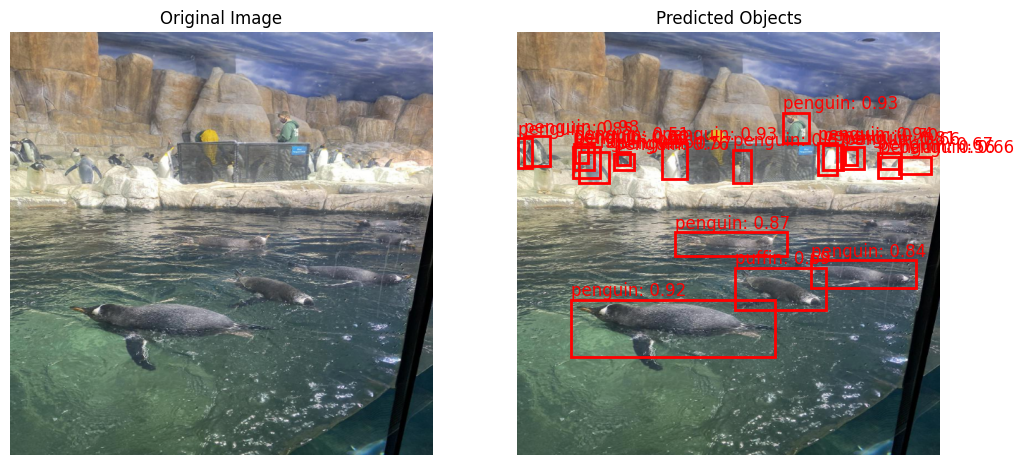

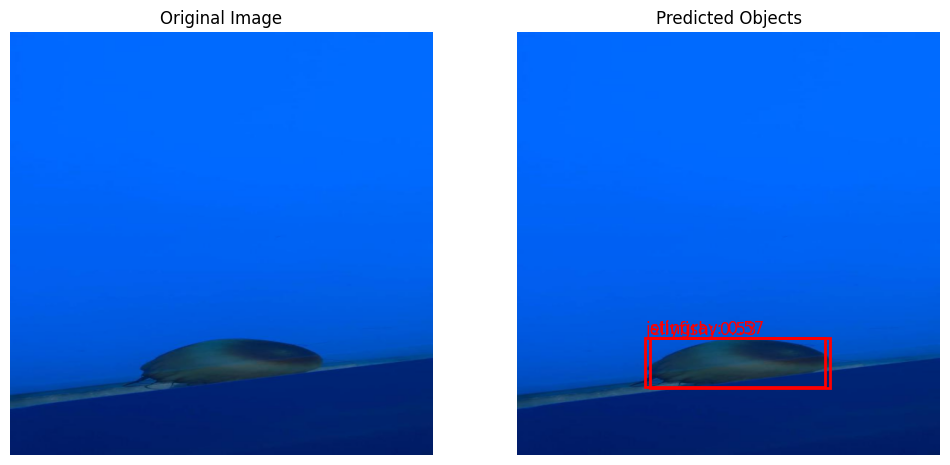

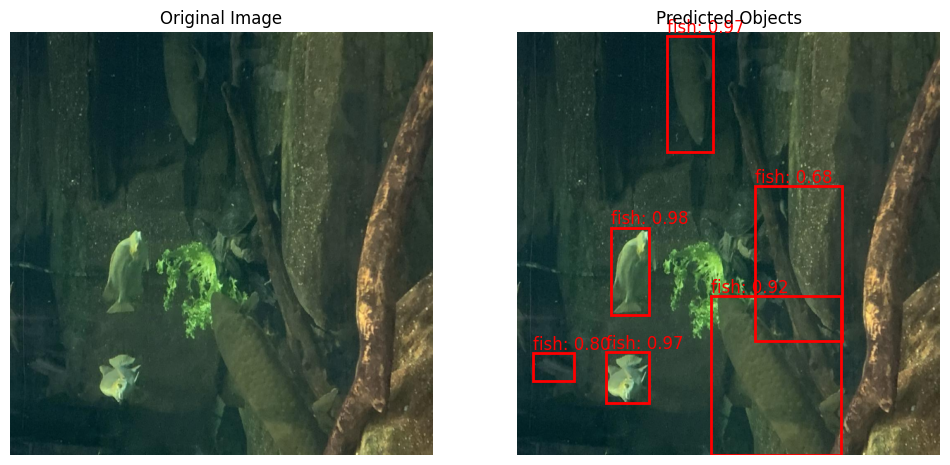

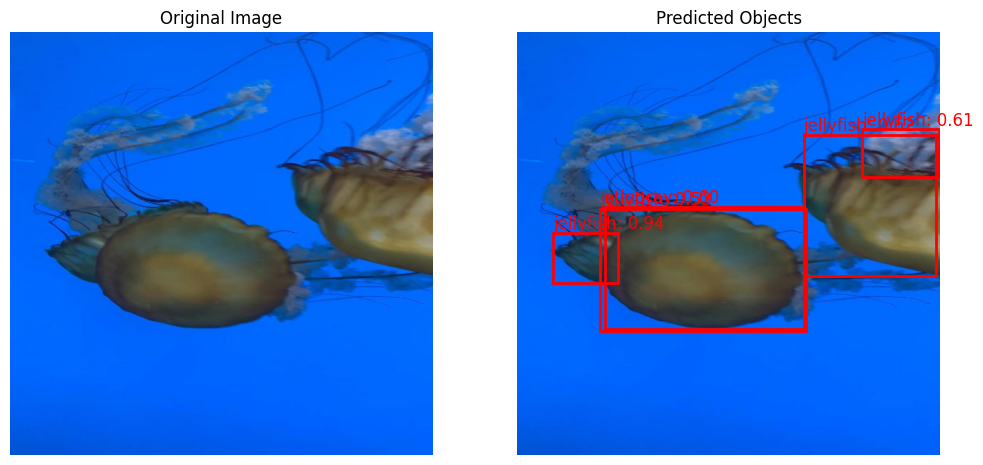

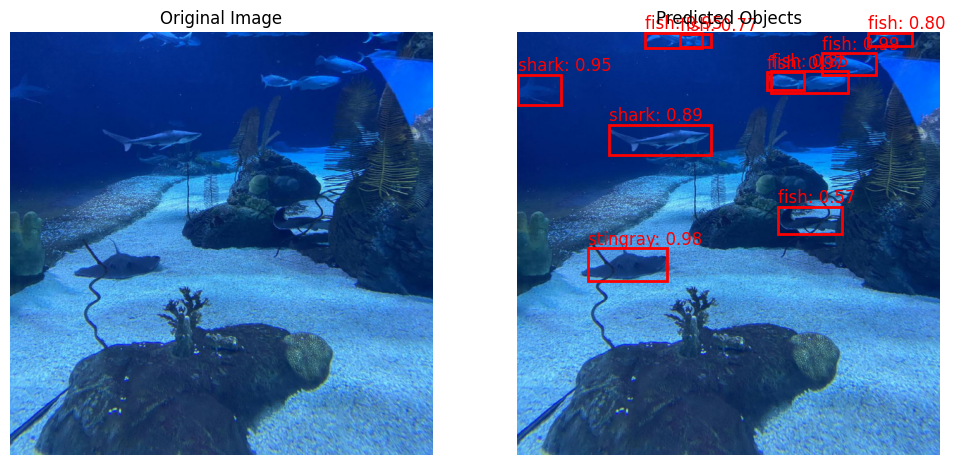

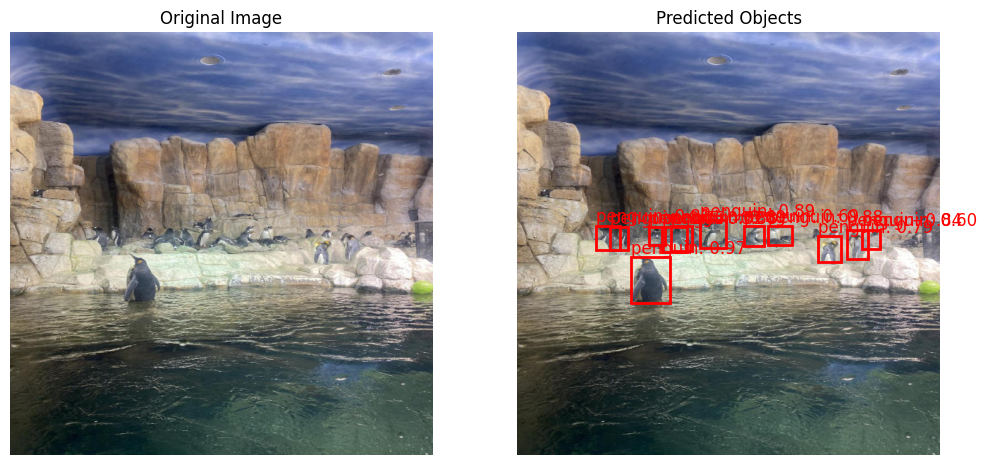

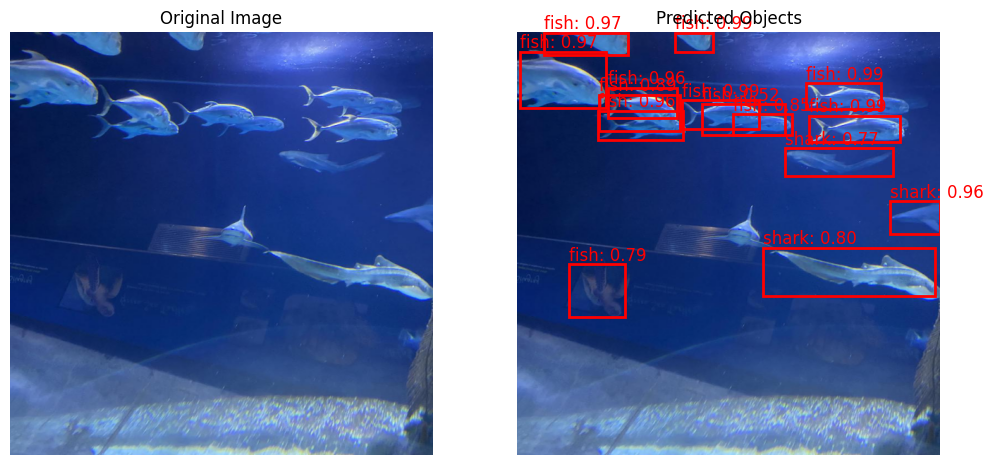

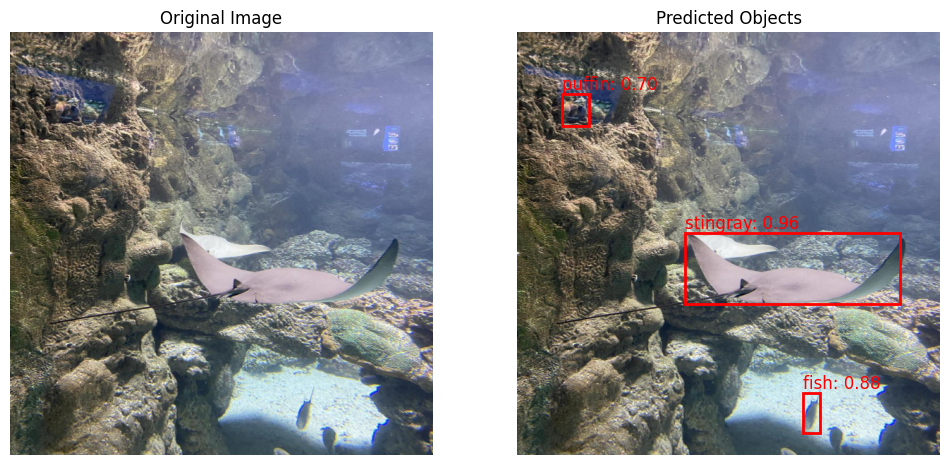

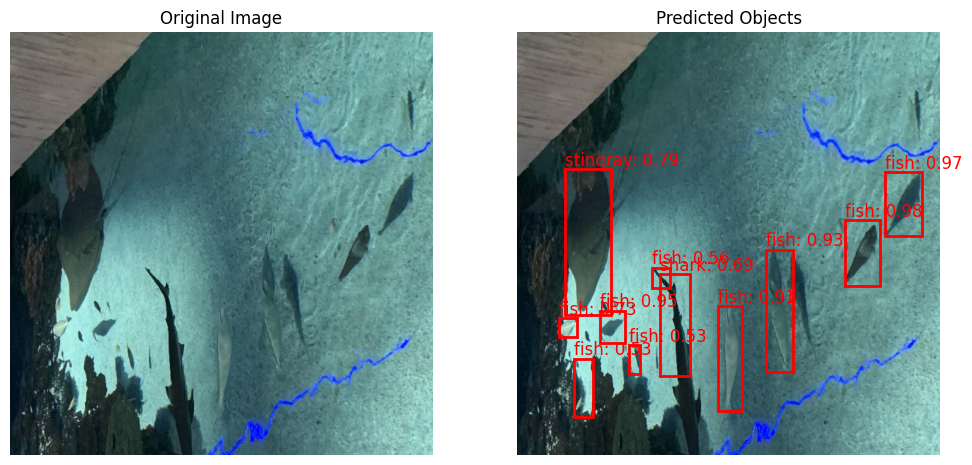

In [27]:
# Load labels map from the dataset
labels_map = {v['id']: v['name'] for v in train_dataset.coco.cats.values()}
print(labels_map)

# Create test DataLoader
test_dataset = AquariumDetection(root=dataset_path, split='test', transforms=get_test_transforms())
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Run evaluation
evaluate(model, test_loader, device, labels_map)